In [1]:
import re
import pandas as pd
import anndata
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import seaborn as sns
import sklearn
from scipy.sparse import vstack
from scipy.special import expit
from scipy.stats import pearsonr, spearmanr
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.metrics import accuracy_score, auc, classification_report, roc_curve
from sklearn.model_selection import (
    # LearningCurveDisplay,
    # learning_curve,
    train_test_split,
)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.metrics._dist_metrics import DistanceMetric
from sklearn.metrics import accuracy_score
import xgboost as xgb

In [5]:
file = "/home/jkuhn/Bachelors-Thesis/input/CountAdded_PIP_global_object_for_cellxgene1.h5ad"
adata_all = sc.read_h5ad(file)
adata_all.var_names_make_unique()
adata_all 

AnnData object with n_obs × n_vars = 329762 × 36601
    obs: 'Organ', 'Donor', 'Chemistry', 'Cell_category', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Majority_voting_CellTypist_high', 'Manually_curated_celltype', 'Sex', 'Age_range'
    uns: 'Age_range_colors', 'Sex_colors'
    obsm: 'X_umap'
    layers: 'counts'

# One hot encoding

In [6]:
encoder_organ = LabelEncoder()
y_encoded = encoder_organ.fit_transform(adata_all.obs["Organ"])  # encode the organ labels

In [7]:
# Replace the existing 'Organ' column with the encoded labels
adata_all.obs["Organ"] = y_encoded

In [8]:
label_table = pd.DataFrame(
    {
        "Encoded_Label": encoder_organ.transform(encoder_organ.classes_),
        "Decoded_Label": encoder_organ.classes_,
    }
)

# Print the table
print(label_table)

    Encoded_Label Decoded_Label
0               0           BLD
1               1           BMA
2               2           CAE
3               3           DUO
4               4           ILE
5               5        JEJEPI
6               6         JEJLP
7               7           LIV
8               8           LLN
9               9           LNG
10             10           MLN
11             11           OME
12             12           SCL
13             13           SKM
14             14           SPL
15             15           TCL
16             16           THY


### Subsetting the dataset: 

In [9]:
celltype = "pDC"

In [10]:
adata = adata_all[(adata_all.obs["Majority_voting_CellTypist_high"] == celltype)]

In [11]:
adata

View of AnnData object with n_obs × n_vars = 791 × 36601
    obs: 'Organ', 'Donor', 'Chemistry', 'Cell_category', 'Predicted_labels_CellTypist', 'Majority_voting_CellTypist', 'Majority_voting_CellTypist_high', 'Manually_curated_celltype', 'Sex', 'Age_range'
    uns: 'Age_range_colors', 'Sex_colors'
    obsm: 'X_umap'
    layers: 'counts'

In [ ]:
# split for each chem and organ for this celltype into train and test
def ttsplit(celltype: str) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame):
    count = 0

    subset_celltype = adata[(adata.obs["Majority_voting_CellTypist_high"] == celltype)]

    for chem in subset_celltype.obs["Chemistry"].unique():
        subset_chemistry = subset_celltype[
                (subset_celltype.obs["Chemistry"] == chem)
            ]

        for organ in subset_chemistry.obs["Organ"].unique(): 

            subset_organ = subset_chemistry[(subset_chemistry.obs["Organ"] == organ)]
            X = subset_organ.to_df()
            y = subset_organ.obs["Organ"]
            subset_name = f"{celltype}_{organ}_{chem}"
    
            try:
                if count != 0:
                    X_train_pre, X_test_pre, y_train_pre, y_test_pre = train_test_split(
                        X, y, test_size=0.2, random_state=42
                    )

                    X_test = pd.concat([X_test, X_test_pre])
                    X_train = pd.concat([X_train, X_train_pre])
                    y_test = pd.concat([y_test, y_test_pre])
                    y_train = pd.concat([y_train, y_train_pre])
                    count = count + 1

                else:
                    X_train, X_test, y_train, y_test = train_test_split(
                        X, y, test_size=0.2, random_state=42
                    )
                    count = count + 1

            except ValueError as e:

                num_elements = X.shape[0]

                if num_elements == 1:
                    X_train_pre, X_test_pre, y_train_pre, y_test_pre = X, None, y, None

                    X_test = pd.concat([X_test, X_test_pre])
                    X_train = pd.concat([X_train, X_train_pre])
                    y_test = pd.concat([y_test, y_test_pre])
                    y_train = pd.concat([y_train, y_train_pre])

                else:
                    print(f"Subset with name '{subset_name}' caused an error: {e}")

                continue
    return X_train, X_test, y_train, y_test

In [13]:
def save_model(bst: xgb.Booster, modelname: str):
    print("modelname: " + model_name)
    # save model
    bst.save_model(model_name)

In [15]:
def load_model(modelname: str) -> xgb.Booster:
    bst = xgb.Booster()
    bst.load_model(modelname)
    return bst

In [ ]:
def prediction(bst: xgb.Booster) -> pd.DataFrame: # gets model and returns classification report, y_pred_encoded oder adata mit prediction
    y_pred_prob = bst.predict(dtest) # predict
    y_pred_encoded = np.argmax(y_pred_prob, axis =1)

    accuracy = accuracy_score(y_test, y_pred_encoded)
    print(f"Accuracy: {accuracy}")
    
    y_test_decoded = encoder_organ.inverse_transform(
        y_test
    ) 
    y_pred_encoded_series = pd.Series(y_pred_encoded)

    # Map the encoded labels to decoded labels using the label table DataFrame
    y_pred = y_pred_encoded_series.map(
        dict(zip(label_table["Encoded_Label"], label_table["Decoded_Label"]))
    )

    class_report = metrics.classification_report(y_test, y_pred_encoded)

    print("Classification Report for celltype: ", celltype)
    print(class_report)

    with open(report_name, "a") as f:
        print("Classification Report for celltype:", celltype, file=f)
        print(class_report, file=f)

    result_df = pd.DataFrame({"Actual": y_test, "Predicted": y_pred_encoded})

    actual_counts = result_df["Actual"].value_counts()
    predicted_counts = result_df["Predicted"].value_counts()
    combined_counts = pd.concat([actual_counts, predicted_counts], axis=1)
    combined_counts.columns = ["Actual", "Predicted"]
    combined_counts = combined_counts.fillna(0)  # Fill NaN values with 0

    # Plot the distributions
    combined_counts.plot(kind="bar", figsize=(12, 6))
    plt.title("Distribution of Actual and Predicted Categories for " + celltype)
    plt.xlabel("Category")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.legend(["Actual", "Predicted"])
    plt.show()

    return y_pred_encoded

In [18]:
X_train, X_test, y_train, y_test = ttsplit(celltype) 
X = adata.to_df()
y = adata.obs["Organ"]

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [19]:
num_classes = len(encoder_organ.classes_)
print("Number of classes:", num_classes)
class_names = encoder_organ.classes_
model_number = "0005"
report_name = f"{model_number}_classification_report.txt"

Number of classes: 17


# Parameter Tuning
Here, the following tutorial was adapted: https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f

In [20]:
params = {
    'max_depth':5,
    'min_child_weight': 15,
    'eta':0.05,
    'subsample': 1,
    'colsample_bytree': 0.7,
    "num_class": num_classes,
    # Other parameters
    "objective": "multi:softprob",
    "eval_metric": ['merror','mlogloss'], 
    'device': 'cuda'
}

### Parameters num_boost_round and early_stopping_rounds

In [21]:
# train model with that
evals_result = {}

model = xgb.train(
    params,
    dtrain,
    num_boost_round=999,
    evals=[(dtrain, "train"), (dtest, "eval")],
    early_stopping_rounds=10,
    evals_result = evals_result
)
print("Best merror: {:.2f} in {} rounds".format(model.best_score, model.best_iteration+1))

[16:57:53] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1705650052425/work/src/context.cc:44: No visible GPU is found, setting device to CPU.


[0]	train-merror:0.36160	train-mlogloss:2.65089	eval-merror:0.40964	eval-mlogloss:2.66099
[1]	train-merror:0.35680	train-mlogloss:2.50486	eval-merror:0.39759	eval-mlogloss:2.53208
[2]	train-merror:0.36320	train-mlogloss:2.38129	eval-merror:0.40361	eval-mlogloss:2.42109
[3]	train-merror:0.35360	train-mlogloss:2.27308	eval-merror:0.42169	eval-mlogloss:2.32871
[4]	train-merror:0.34720	train-mlogloss:2.17706	eval-merror:0.40361	eval-mlogloss:2.24031
[5]	train-merror:0.33280	train-mlogloss:2.09155	eval-merror:0.40964	eval-mlogloss:2.16556
[6]	train-merror:0.32640	train-mlogloss:2.01546	eval-merror:0.39157	eval-mlogloss:2.10425
[7]	train-merror:0.32000	train-mlogloss:1.94322	eval-merror:0.38554	eval-mlogloss:2.04452
[8]	train-merror:0.30240	train-mlogloss:1.87311	eval-merror:0.37349	eval-mlogloss:1.98865
[9]	train-merror:0.28960	train-mlogloss:1.81168	eval-merror:0.38554	eval-mlogloss:1.93466
[10]	train-merror:0.28480	train-mlogloss:1.75559	eval-merror:0.37952	eval-mlogloss:1.88788
[11]	trai

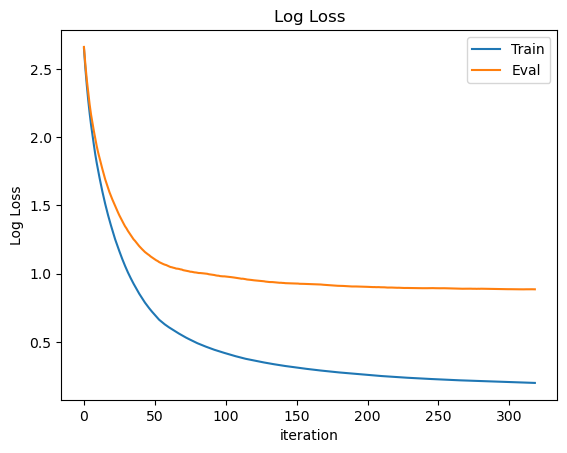

In [22]:
epochs = len(evals_result['train']['mlogloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, evals_result['train']['mlogloss'], label='Train')
ax.plot(x_axis, evals_result['eval']['mlogloss'], label='Eval')
ax.legend()
plt.ylabel('Log Loss')
plt.xlabel('iteration')
plt.title('Log Loss')
plt.show()

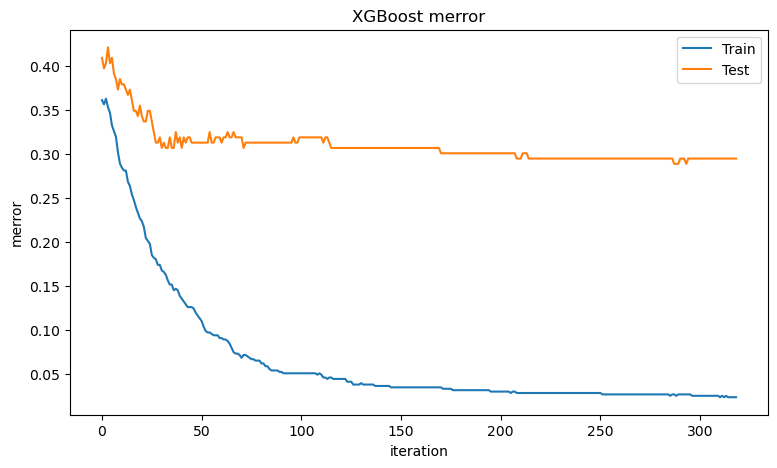

In [23]:
# xgboost 'merror' plot
fig, ax = plt.subplots(figsize=(9,5))
ax.plot(x_axis, evals_result['train']['merror'], label='Train')
ax.plot(x_axis, evals_result['eval']['merror'], label='Test')
ax.legend()
plt.ylabel('merror')
plt.xlabel('iteration')
plt.title('XGBoost merror')
plt.show()

In [24]:
# saving that 
evals_result = {}

num_boost_round = model.best_iteration + 1
best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    evals_result = evals_result
)

[17:08:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1705650052425/work/src/context.cc:44: No visible GPU is found, setting device to CPU.


[0]	Test-merror:0.40964	Test-mlogloss:2.66099
[1]	Test-merror:0.39759	Test-mlogloss:2.53208
[2]	Test-merror:0.40361	Test-mlogloss:2.42109
[3]	Test-merror:0.42169	Test-mlogloss:2.32871
[4]	Test-merror:0.40361	Test-mlogloss:2.24031
[5]	Test-merror:0.40964	Test-mlogloss:2.16556
[6]	Test-merror:0.39157	Test-mlogloss:2.10425
[7]	Test-merror:0.38554	Test-mlogloss:2.04452
[8]	Test-merror:0.37349	Test-mlogloss:1.98865
[9]	Test-merror:0.38554	Test-mlogloss:1.93466
[10]	Test-merror:0.37952	Test-mlogloss:1.88788
[11]	Test-merror:0.37952	Test-mlogloss:1.84628
[12]	Test-merror:0.37349	Test-mlogloss:1.80667
[13]	Test-merror:0.36747	Test-mlogloss:1.76638
[14]	Test-merror:0.37349	Test-mlogloss:1.72767
[15]	Test-merror:0.36145	Test-mlogloss:1.69058
[16]	Test-merror:0.34940	Test-mlogloss:1.65946
[17]	Test-merror:0.34940	Test-mlogloss:1.62735
[18]	Test-merror:0.34337	Test-mlogloss:1.59699
[19]	Test-merror:0.35542	Test-mlogloss:1.57008
[20]	Test-merror:0.34337	Test-mlogloss:1.54443
[21]	Test-merror:0.3373

In [25]:
best_model.save_model("bestPdc_softprob.model")

[17:18:35] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1705650052425/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [26]:
# use model later: 
loaded_model = xgb.Booster()
loaded_model.load_model("bestPdc_softprob.model")

In [27]:
print("training done")
y_pred_prob = loaded_model.predict(dtest)
y_pred_encoded = np.argmax(y_pred_prob, axis =1)

accuracy = accuracy_score(y_test, y_pred_encoded)
print ("SCORE:", accuracy)

training done
SCORE: 0.7048192771084337


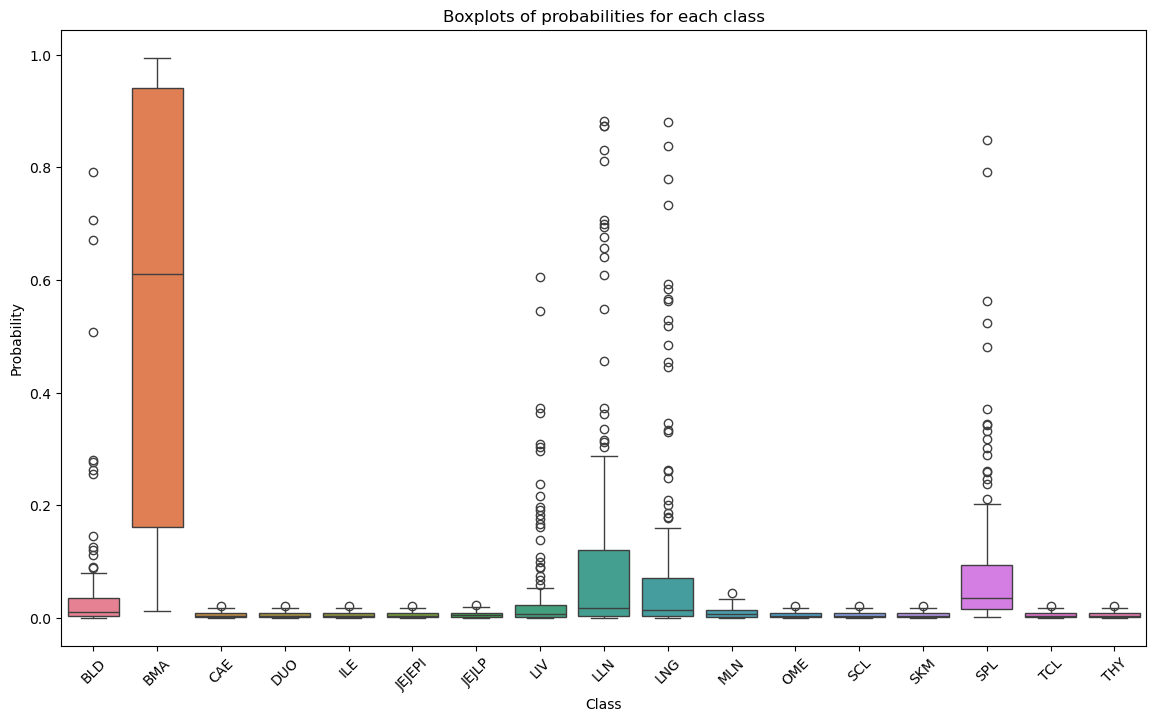

In [29]:
# Convert class indices to class labels
class_labels = label_table['Decoded_Label'].tolist()
df = pd.DataFrame(y_pred_prob, columns=class_labels)

# Boxplot for each class
plt.figure(figsize=(14, 8))
sns.boxplot(data=df)
plt.title('Boxplots of probabilities for each class')
plt.xlabel('Class')
plt.ylabel('Probability')
plt.xticks(rotation=45)
plt.show()

## Apply on Exercise Dataset

In [30]:
file = "adata_final.h5ad"
print("reading file")
adata2 = sc.read_h5ad(file)
modelname = "Pdc"

reading file


In [31]:
bst = xgb.Booster()
bst.load_model("bestPdc_softprob.model")

In [32]:
subset = adata2[(adata2.obs["celltypist_cell_label_coarse"] == "pDC")]
X = subset.to_df()
deval = xgb.DMatrix(X) 

In [33]:
y_pred_prob_ex = loaded_model.predict(deval) # predict
predictions = np.argmax(y_pred_prob_ex, axis =1)

In [34]:
label_mapping = {
            0: 'BLD',
            1: 'BMA',
            2: 'CAE',
            3: 'DUO',
            4: 'ILE',
            5: 'JEJEPI',
            6: 'JEJLP',
            7: 'LIV',
            8: 'LLN',
            9: 'LNG',
            10: 'MLN',
            11: 'OME',
            12: 'SCL',
            13: 'SKM',
            14: 'SPL',
            15: 'TCL',
            16: 'THY'
}

In [35]:
# Add predictions to the subset
subset.obs["Predicted_tissue"] = [label_mapping[int(pred)] for pred in predictions]
subset.obs["celltype_model"] = modelname

Trying to modify attribute `.obs` of view, initializing view as actual.


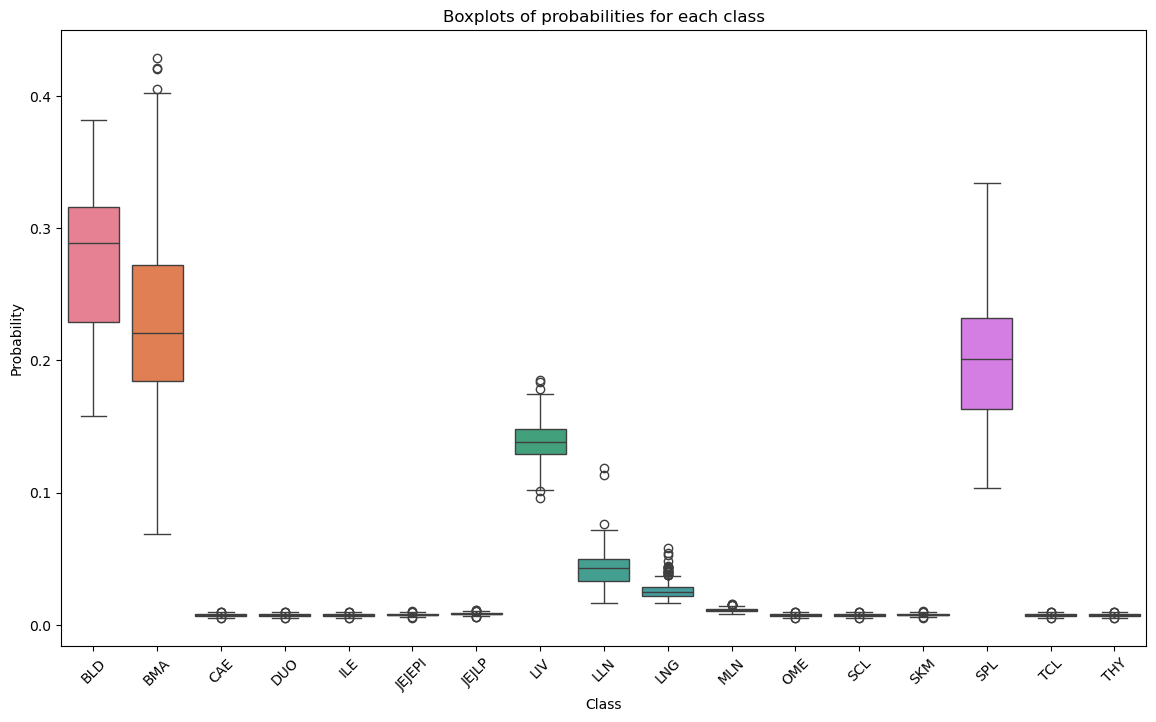

In [36]:
# Convert class indices to class labels
class_labels = [label_mapping[i] for i in range(y_pred_prob_ex.shape[1])]
df = pd.DataFrame(y_pred_prob_ex, columns=class_labels)

# Boxplot for each class
plt.figure(figsize=(14, 8))
sns.boxplot(data=df)
plt.title('Boxplots of probabilities for each class')
plt.xlabel('Class')
plt.ylabel('Probability')
plt.xticks(rotation=45)
plt.show()

In [39]:
# Extract 'timepoint' and 'Predicted_tissue' columns
data = {
    'timepoint': subset.obs['timepoint'],
    'Predicted_tissue': subset.obs['Predicted_tissue']
}
df = pd.DataFrame(data)

df = pd.DataFrame(data)

# Group by timepoint and calculate predicted tissue value counts for each timepoint
predicted_tissue_counts_by_timepoint = df.groupby('timepoint')['Predicted_tissue'].value_counts()

# Print the predicted tissue value counts for each timepoint
for timepoint, counts in predicted_tissue_counts_by_timepoint.groupby(level=0):
    print(f"Timepoint {timepoint}:")
    for tissue, count in counts.items():
        print(f"{tissue}\t{count}")
    print()


Timepoint 5b:
('5b', 'BLD')	37
('5b', 'BMA')	14
('5b', 'SPL')	4

Timepoint 5a:
('5a', 'BLD')	22
('5a', 'BMA')	16
('5a', 'SPL')	8

Timepoint 30a:
('30a', 'BLD')	35
('30a', 'BMA')	16
('30a', 'SPL')	5

Timepoint 120a:
('120a', 'BLD')	138
('120a', 'BMA')	65
('120a', 'SPL')	27

